In [1]:
import os

os.environ["XLA_PYTHON_CLIENT_MEM_FRACTION"] = "0.97"

import fwd_model_tools as ffi
import jax
import jax.numpy as jnp
import jax_cosmo as jc
import matplotlib.pyplot as plt

print(f"Devices {jax.devices()}")
jax.print_environment_info()

Devices [CudaDevice(id=0)]
jax:    0.9.0.1
jaxlib: 0.9.0.1
numpy:  2.4.2
python: 3.11.5 | packaged by conda-forge | (main, Aug 27 2023, 03:34:09) [GCC 12.3.0]
device info: NVIDIA H100 80GB HBM3-1, 1 local devices"
process_count: 1
platform: uname_result(system='Linux', node='jzxh048', release='5.14.0-570.58.1.el9_6.x86_64', version='#1 SMP PREEMPT_DYNAMIC Tue Oct 21 04:15:07 EDT 2025', machine='x86_64')
XLA_PYTHON_CLIENT_MEM_FRACTION=0.97

$ nvidia-smi
Tue Feb 17 22:08:55 2026       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 580.126.16             Driver Version: 580.126.16     CUDA Version: 13.0     |
+-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |        

In [2]:
key = jax.random.PRNGKey(0)
resolution = 512
mesh_size = (resolution,) * 3
box_size = (1000.0, 1000.0, 1000.0)
nside = resolution
flatsky_npix = (resolution, resolution)
field_size = (10, 10)
nb_shells = 4
cosmo = jc.Planck18()
ts = jnp.array([0.2, 0.4, 1.0])

initial_field = ffi.gaussian_initial_conditions(
    key,
    mesh_size,
    box_size,
    cosmo=cosmo,
    nside=nside,
    flatsky_npix=flatsky_npix,
    field_size=field_size,
    observer_position=(0.0, 0.0, 0.0),
)

# LPT at early time to initialize PM
t0 = 0.1
dx, p = ffi.lpt(cosmo, initial_field, ts=t0, order=1, painting=ffi.PaintingOptions(target="particles"))
print(f"LPT initialized at a={t0}")
print(f"Displacement status: {dx.status}")

LPT initialized at a=0.1
Displacement status: FieldStatus.LPT1


In [3]:
furthest_requested_scale_factor = jnp.min(ts)
furthest_scale_factor = jc.background.a_of_chi(cosmo, initial_field.max_comoving_radius).squeeze()
needed_comoving_distance = jc.background.radial_comoving_distance(cosmo, furthest_requested_scale_factor).squeeze()

print(f"Furthest scale factor of the shells: {furthest_requested_scale_factor:.3f}")
print(f"Furthest scale factor of the box: {furthest_scale_factor:.3f}")
print(f"Number of replications needed: {jnp.ceil(needed_comoving_distance / box_size[0]):.1f}")

Furthest scale factor of the shells: 0.200
Furthest scale factor of the box: 0.732
Number of replications needed: 5.0


Se we need to make 5 replications of the box and to do that you can use the `TelephotoInterp` interpolation kernel which will automatically replicate the box as needed to make sure that the painting is correct. You can also use the `nb_shells` argument to make sure that the snapshots are equally spaced in comoving distance and that the furthest one is inside the box.

The maximum amounts of shells is 47 because of the symmetries of the cube. and this only supports flat sky painting. 

In [4]:
solver_kkd = ffi.ReversibleDoubleKickDrift(
    interp_kernel=ffi.TelephotoInterp(painting=ffi.PaintingOptions(target="flat"), drift_on_lightcone=False),
)
solver_no_replicate = ffi.ReversibleDoubleKickDrift(
    interp_kernel=ffi.NoInterp(painting=ffi.PaintingOptions(target="flat")),
)


result_kkd = ffi.nbody(
    cosmo,
    dx,
    p,
    t1=1.0,
    dt0=0.05,
    ts=ts,
    solver=solver_kkd,
).block_until_ready()

print("==" * 20)

result_no_replicate = ffi.nbody(
    cosmo,
    dx,
    p,
    t1=1.0,
    dt0=0.05,
    ts=ts,
    solver=solver_no_replicate,
)

/lustre/fswork/projects/rech/tkc/commun/venv/pm/lib/python3.11/site-packages/jax/_src/debugging.py:201: UserWarning: 
                NoInterp does not support tiling.
                Your furthest shell is at 5379.19 Mpc/h,
                but your box only extends to 1000.00 Mpc/h.
                Your simulations will run but will have artifacts for the far shells.
            
  debug_callback_p.impl(


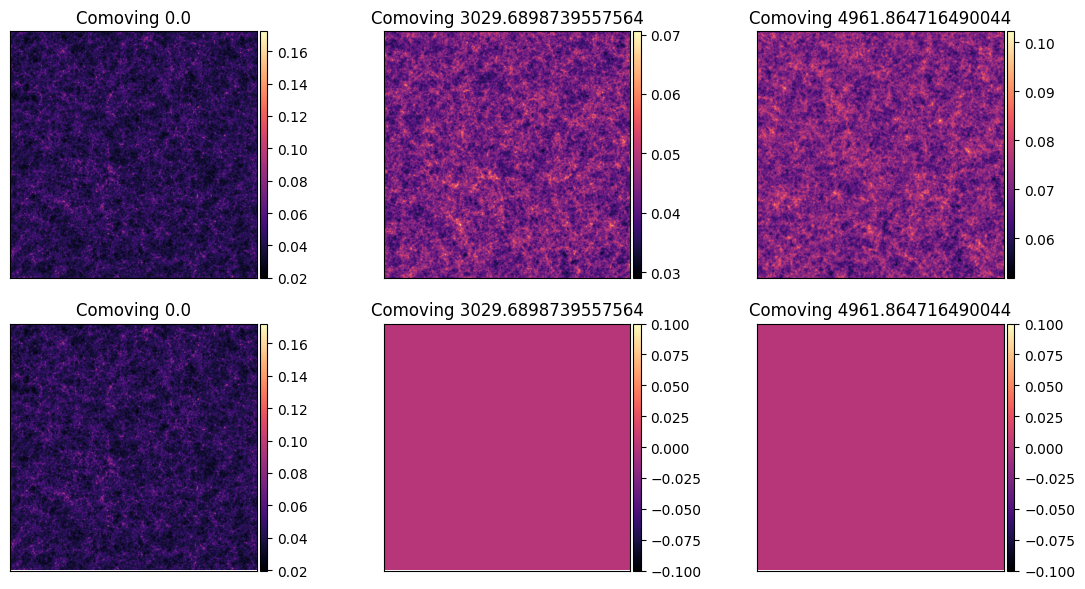

In [5]:
fig, axes = plt.subplots(2, 3, figsize=(12, 6))
result_kkd.apply_fn(jnp.log1p).plot(
    ax=axes[0], show_ticks=False, titles=[f"Comoving {i}" for i in result_kkd.comoving_centers]
)
result_no_replicate.apply_fn(jnp.log1p).plot(
    ax=axes[1], show_ticks=False, titles=[f"Comoving {i}" for i in result_no_replicate.comoving_centers]
)

plt.tight_layout()
plt.show()

So you can see that the density that does not intersect the box is zeros (nothing is painted) but with the `TelephotoInterp` interpolation kernel the density is correctly painted

# Spherical painting

for spherical painting `TelephotoInterp` does not work since it only replicates the box in the plane of the sky but not along the line of sight. In this case you can use the `OnionTiler` which will replicate the box along the line of sight as well.

The amount of replication follows this simple formula: $(2 \times \text{nb\_shells} + 1)^3$ so for 1 shell ouside the box you need to replicate the box 27 times.

`OnionTiler` only supports a single replication step (as in 27 boxes) so you need to make sure that the furthest shell is within the replicated box.



In [6]:
initial_field = ffi.gaussian_initial_conditions(
    jax.random.key(1),
    mesh_size,
    box_size,
    cosmo=cosmo,
    nside=nside,
    flatsky_npix=flatsky_npix,
    field_size=field_size,
    observer_position=(0.5, 0.5, 0.5),
)

# LPT at early time to initialize PM
t0 = 0.1
dx, p = ffi.lpt(cosmo, initial_field, ts=t0, order=1, painting=ffi.PaintingOptions(target="particles"))


max_radius = initial_field.max_comoving_radius
max_possible_radius = max_radius * 2
max_a = jc.background.a_of_chi(cosmo, max_possible_radius).squeeze()
ts = jnp.linspace(max_a, 1.0, 3)


solver_kkd = ffi.ReversibleDoubleKickDrift(
    interp_kernel=ffi.TelephotoInterp(painting=ffi.PaintingOptions(target="spherical"), drift_on_lightcone=False),
)
solver_onion = ffi.ReversibleDoubleKickDrift(
    interp_kernel=ffi.OnionTiler(painting=ffi.PaintingOptions(target="spherical"), drift_on_lightcone=False),
)
solver_no_replicate = ffi.ReversibleDoubleKickDrift(
    interp_kernel=ffi.NoInterp(painting=ffi.PaintingOptions(target="spherical")),
)

result_kkd = ffi.nbody(
    cosmo,
    dx,
    p,
    t1=1.0,
    dt0=0.05,
    ts=ts,
    solver=solver_kkd,
)

result_no_replicate = ffi.nbody(cosmo, dx, p, t1=1.0, dt0=0.05, ts=ts, solver=solver_no_replicate)

result_onion = ffi.nbody(cosmo, dx, p, t1=1.0, dt0=0.05, ts=ts, solver=solver_onion)

/lustre/fswork/projects/rech/tkc/commun/NBody/fwd-model-tools/src/fwd_model_tools/pm/interp.py:501: UserWarning: 
            TelephotoInterp is designed for narrow FOV flat-sky projections.
            Using it for spherical painting will cause significant artifacts.
            use for illustriative purposes only.
            
  warnings.warn("""
/lustre/fswork/projects/rech/tkc/commun/venv/pm/lib/python3.11/site-packages/jax/_src/debugging.py:201: UserWarning: 
                NoInterp does not support tiling.
                Your furthest shell is at 1329.67 Mpc/h,
                but your box only extends to 500.00 Mpc/h.
                Your simulations will run but will have artifacts for the far shells.
            
  debug_callback_p.impl(


/lustre/fswork/projects/rech/tkc/commun/venv/pm/lib/python3.11/site-packages/healpy/visufunc.py:1630: HealpyDeprecationWarning: "verbose" was deprecated in version 1.15.0 and will be removed in a future version. 
  ax.graticule(dpar=dpar, dmer=dmer, coord=coord, local=local, **kwds)


/tmp/ipykernel_247213/2740041227.py:6: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


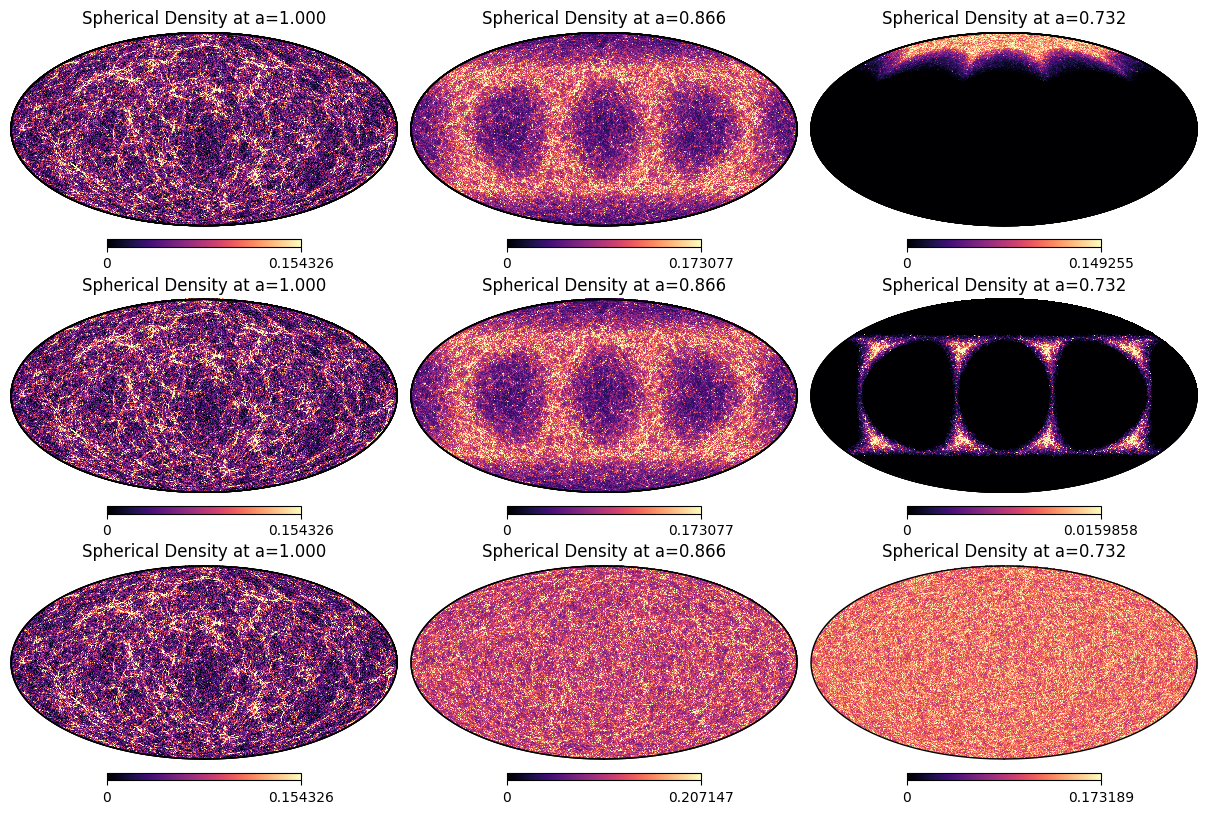

In [7]:
fig, axes = plt.subplots(3, 3, figsize=(12, 8))
result_kkd.apply_fn(jnp.log1p).plot(ax=axes[0], show_ticks=False)
result_no_replicate.apply_fn(jnp.log1p).plot(ax=axes[1], show_ticks=False)
result_onion.apply_fn(jnp.log1p).plot(ax=axes[2], show_ticks=False)

plt.tight_layout()
plt.show()

The telephoto interpolation only fills the of the sphere which is what the observer has infront of him

While you can see that using no interp this causes the furthest shell to be usually empty or have circular artifacts because the far particles intersecging only with the corner of the box these artifacts are apparent even on particle fields that are mostly inside

Using the `OnionTiler` interpolation kernel, the painting is correct and there are no artifacts even for the furthest shell.

